<a href="https://colab.research.google.com/github/dosepix/DosepixCalibration/blob/main/DNN_calibration_genData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import dill

from IPython.display import Image
from IPython.core.display import HTML

import json
import tqdm

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os, sys
directory = '/content/gdrive/My Drive/Colab Notebooks/calib_data/'
sys.path.insert(0, directory)

In [ ]:
SIMPLE = False
def energyToToTSimple(x, a, b, c, t):
    if SIMPLE:
        thl = getTHL(a, b, c, t)
        res = np.where(x > thl, a*(x - b) - c * (np.pi / 2 + t / (x - b)), 0)
        # res = np.where(x > thl, a*x - c * (np.pi / 2 + t / (x - b)), 0)
        return res
    else:
	      return np.where(x >= getTHL(a, b, c, t), a*x + b + float(c)/(x - t), 0)

def ToTtoEnergySimple(x, a, b, c, t, h=1, k=0):
    if SIMPLE:
        return h * (b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))) + k
    else:
      	return 1./(2*a) * ( t*a + x - b + np.sqrt((b + t*a - x)**2 - 4*a*c) )

def getTHL(a, b, c, t):
    if SIMPLE:
        return (4*a*b + np.sqrt(c * (16 * a * t + np.pi**2 * c)) + np.pi * c) / (4 * a)
    else:
        return 1./(2*a) * ( t*a - b + np.sqrt((b + t*a)**2 - 4*a*c) )

def get_t(THL, a, b, c):
    return (2*a*b**2 - 4*a*b*THL + 2*a*THL**2 + np.pi*b*c - np.pi*c*THL)/(2*c)

def expDecay(x, A, k, c):
    return A * np.exp(-k * x) + c

def smearSpectrumFunction(data, sigmaParams):
    data = np.asarray( data )
    sigma = np.abs(expDecay(data, *sigmaParams))
    data_smear = np.random.normal(data, scale=sigma)
    return data_smear

def getColor(c, N, idx):
    import matplotlib as mpl
    cmap = mpl.cm.get_cmap(c)
    norm = mpl.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

## Generate data

In [ ]:
def genSpectrum(sources, dataDict, frac,
                aRange=(0.5, 5.5), bRange=(5, 12), 
                cRange=(-80, -30), tRange=(-2.5, -1),
                NRange=(5000, 100000), sigmaParams0=[2.49, 0.09, 1.06],
                p_norm=[2.5, 8.5, -55, -1.75], batch_size=1, 
                progress=False):
    while True:
        batchOut, paramsOut = [], []
        for batch in tqdm.tqdm(range(batch_size)):
            N = np.random.randint(*NRange)
            dataSmear = []
            fr = []
            for idx, source in enumerate( sources ):
                fr.append( np.random.uniform(*frac[idx]) )
            fr = np.asarray( fr )

            for idx, source in enumerate( sources ):
                data = np.random.choice(dataDict[source], int(N * fr[idx] / np.sum(fr)), replace=True)
                dataSmear += list(data)

            dataSmear = np.asarray(dataSmear)
            if sigmaParams0 is not None:
                sigmaParams0 = np.asarray(sigmaParams0)
                sigmaParams = np.random.normal(sigmaParams0, 0.1*sigmaParams0)
                dataSmear = smearSpectrumFunction(dataSmear, sigmaParams)

            p = np.full(4, 10)
            while energyToToTSimple(np.asarray([70]), *p) > 400:
                a = np.random.uniform(*aRange)
                b = np.random.uniform(*bRange)
                c = np.random.uniform(*cRange)
                t = np.random.uniform(*tRange)
                p = [a, b, c, t]
                THL = getTHL(*p)
            paramsOut.append( p )

            hist, bins = np.histogram(energyToToTSimple(dataSmear[dataSmear >= THL], *p), bins=np.arange(401))
            # plt.hist(dataSmear[dataSmear >= THL], bins=300, histtype='step')

            hist = np.asarray(hist, dtype=float)
            hist /= float(np.max(hist))
            batchOut.append( hist )
        batchOut, paramsOut = np.asarray(batchOut), np.asarray(paramsOut) / np.asarray(p_norm)
        yield batchOut.reshape(np.append(batchOut.shape, 1)), paramsOut

def genSpectrumTrue(sources, dataDict, frac,
                aRange=(0.5, 5.5), bRange=(5, 12), 
                cRange=(-80, -30), tRange=(-2.5, -1),
                NRange=(5000, 100000), sigmaParams0=[2.49, 0.09, 1.06],
                p_norm=[2.5, 8.5, -55, -1.75], batch_size=1, 
                progress=False):
    while True:
        batchOut = []
        for batch in tqdm.tqdm(range(batch_size)):
            N = np.random.randint(*NRange)
            dataSmear = []
            fr = []
            for idx, source in enumerate( sources ):
                fr.append( np.random.uniform(*frac[idx]) )
            fr = np.asarray( fr )

            for idx, source in enumerate( sources ):
                data = np.random.choice(dataDict[source], int(N * fr[idx] / np.sum(fr)), replace=True)
                dataSmear += list(data)

            dataSmear = np.asarray(dataSmear)
            if sigmaParams0 is not None:
                sigmaParams0 = np.asarray(sigmaParams0)
                sigmaParams = np.random.normal(sigmaParams0, 0.1*sigmaParams0)
                dataSmear = smearSpectrumFunction(dataSmear, sigmaParams)

            hist, bins = np.histogram(dataSmear, bins=np.linspace(5, 70, 300))
            hist = np.asarray(hist, dtype=float)
            hist /= float(np.max(hist))
            batchOut.append( hist )
        batchOut = np.asarray(batchOut)
        yield batchOut

def dump_json(fn, x, y):
    with open(fn, 'w') as f:
        json.dump({'x': x.tolist(), 'y': y.tolist()}, f)

def generateSmallPixelSpectrum(x, rgi, attributes):
    y = np.zeros(len(x))
    for att in attributes:
        energy, prob = att
        for slot in range(1, 3 + 1):
            y += prob * rgi(np.insert(x.reshape((len(x), -1)), [-1], [energy, slot], axis=1))
    return y

# Rejection sampling
def drawFromSpectrum(x, y, N):
    h = y / np.max(y)
    f = scipy.interpolate.interp1d(x, h)

    events = []
    while len(events) < N:
        x_ran = np.random.uniform(x[0], x[-1])
        y_ran = np.random.uniform(0, 1)
        if f(x_ran) > 0 and y_ran <= f(x_ran):
            events.append( x_ran )
    return events

[0.8919583793263883, 63.012214459013194, -137.63798783378056, 10.367089150783917]


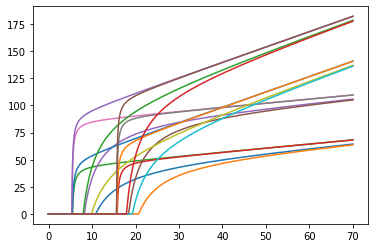

In [ ]:
# Std parameters
# Old parameters
'''
aRange = [.3, 4]
bRange = [100, 200]
cRange = [-500, -50]
tRange = [5, 10]
'''

# Flori parameters
am, bm, cm, tm = 0.8919583793263882, 63.012214459013194, -137.63798783378056, 10.367089150783917
asig, bsig, csig, tsig = 0.17278910886062365, 6.907091107603313, 41.342242483326785, 1.7183509229051794

aRange = [am - 3*asig, am + 3*asig]
bRange = [bm - 3*bsig, bm + 3*bsig]
cRange = [cm - 3*csig, cm + 3*csig]
tRange = [tm - 3*tsig, tm + 3*tsig]

# aRange = [.1, 2]
# bRange = [50, 100]
# cRange = [-500, -50]
# tRange = [3, 10]

p_norm = [np.mean(aRange), np.mean(bRange), np.mean(cRange), np.mean(tRange)]
print(p_norm)

# a, b, c, t = 2.15, 125, -525, 10
x = np.linspace(0, 70, 1000)

for a in aRange:
    for b in bRange:
        for c in cRange:
            for t in tRange:
                plt.plot(x, energyToToTSimple(x, a, b, c, t))

### Large Pixels

#### Load data

In [ ]:
import json
# p_norm = [2.5, 8.5, -55, -1.75]

sources = ['Am', 'Mo', 'Sn', 'Ge']
dataDict = {}
# Load simulation
for source in sources:
    dataDict[source] = json.load(open(directory + 'XRay_%s_out.json' % source))

(15.0, 20.0)

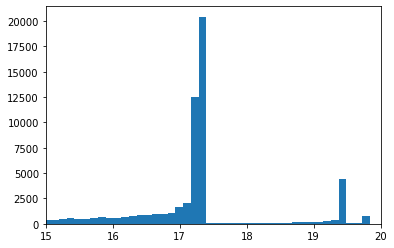

In [ ]:
plt.hist(dataDict['Mo'], bins=300);
plt.xlim(15, 20)

[58.83350632 -1.16415717]
14.25155557571377


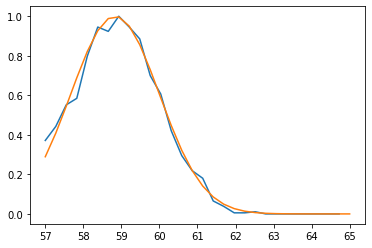

In [ ]:
import scipy.optimize
def normal(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

bins = np.linspace(57, 65, 30)
y = smearSpectrumFunction(dataDict['Am'], [2.49, 0.09, 1.06])
res = np.histogram(y, bins=bins);
plt.plot(bins[:-1], res[0] / np.max(res[0]))

popt, pcov = scipy.optimize.curve_fit(normal, bins[:-1], res[0] / np.max(res[0]), p0=(60, 5))
plt.plot(bins, normal(bins, *popt))
print( popt )
print(np.mean(y[(y < 25) & (y > 10)]))

#### Exemplary plots

100%|██████████| 1024/1024 [00:34<00:00, 30.09it/s]


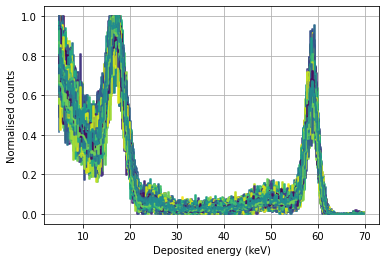

In [ ]:
frac = [(1., 1.), (.6, .8), (0, .05), (0., 0.)]
specGen = genSpectrumTrue(sources, dataDict, frac, 
                      aRange=aRange, bRange=bRange, 
                      cRange=cRange, tRange=tRange, batch_size=1024)
hist = next(specGen)

bins = np.linspace(5, 70, 300)
color = [getColor('viridis', len(hist), h_idx) for h_idx in range(len(hist))]
np.random.shuffle(color)
for h_idx, h in enumerate(hist):
    plt.step(bins[:-1], h, color=color[h_idx])
plt.grid()
plt.xlabel('Deposited energy (keV)')
plt.ylabel('Normalised counts')
plt.savefig('random_AmMo_spectra.pdf', bbox_inches='tight')
plt.show()

Text(0, 0.5, 'Normalised counts')

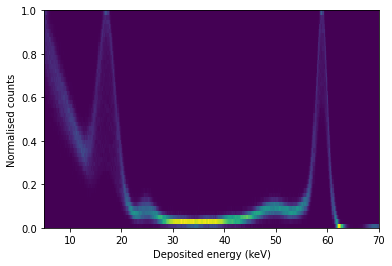

In [ ]:
x_total, y_total = np.asarray(list(bins[:-1])*len(hist)).flatten(), hist.flatten()
filt = y_total > 0.
plt.hist2d(x_total[filt], y_total[filt], bins=[bins, np.linspace(0, 1, 50)]);
plt.xlabel('Deposited energy (keV)')
plt.ylabel('Normalised counts')

100%|██████████| 4/4 [00:00<00:00, 33.44it/s]


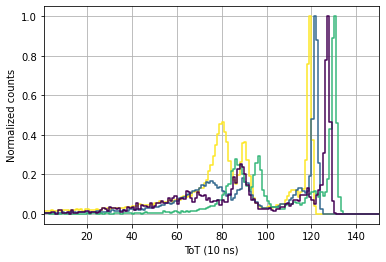

In [ ]:
# frac = [(1., 1.), (.6, .8), (0, .05), (0., 0.)]
# Flori
frac = [(1., 1.), (.1, .6), (.05, .5), (0., 0.)]
specGen = genSpectrum(sources, dataDict, frac, 
                      aRange=aRange, bRange=bRange, 
                      cRange=cRange, tRange=tRange, batch_size=4)
hist = next(specGen)[0]

bins = np.arange(400)
color = [getColor('viridis', len(hist), h_idx) for h_idx in range(len(hist))]
np.random.shuffle(color)
for h_idx, h in enumerate(hist):
    plt.step(bins, h.flatten(), color=color[h_idx])
plt.grid()
plt.xlim(1, 150)
plt.xlabel('ToT (10 ns)')
plt.ylabel('Normalized counts')
plt.show()

#### Generate spectra

In [ ]:
# Flori
frac = [(1., 1.), (.1, .6), (.05, .5), (0., 0.)]

# frac = [(1., 1.), (.6, .8), (0, .05), (0., 0.)]
# frac = [(1., 1.), (.8, 1.5), (0, .05), (0., 0.)]

# Thilo
# frac = [(1., 1.), (.2, .4), (0, .05), (.3, .5)]

specGen = genSpectrum(sources, dataDict, frac, 
                      aRange=aRange, bRange=bRange, 
                      cRange=cRange, tRange=tRange, 
                      p_norm=p_norm, batch_size=40000)
x_train, y_train = next(specGen)
specGen = genSpectrum(sources, dataDict, frac, 
                      aRange=aRange, bRange=bRange, 
                      cRange=cRange, tRange=tRange, 
                      p_norm=p_norm, batch_size=5000)
x_eval, y_eval = next(specGen)

100%|██████████| 5000/5000 [02:33<00:00, 32.54it/s]


In [ ]:
for idx in range(10):
    plt.plot(x_eval[idx])

#### Dump

In [ ]:
dump_json(directory + 'train_flori_2.json', x_train, y_train)
dump_json(directory + 'eval_flori_2.json', x_eval, y_eval)

### Small Pixels

#### Load data

In [ ]:
import scipy.interpolate
inFile = directory + 'regularGridInterpolatorData_smallPixels.json'
with open(inFile, 'r') as f:
    d = json.load(f)

energies, slots, energy_bins = d['energies'], d['slots'], d['energy_bins']
slots = np.asarray(slots)
data = d['counts']
print(np.asarray(data).shape)

rgi = scipy.interpolate.RegularGridInterpolator((energies, slots, energy_bins), data, 
                                                bounds_error=False, fill_value=0)

(54, 3, 3000)


#### Spectrum construction

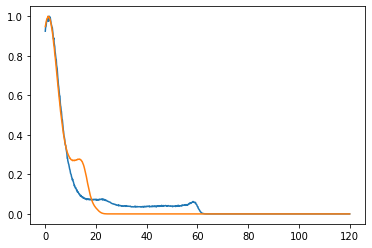

In [ ]:
AmAttributes = np.asarray([[26.3446, 33.196, 59.5409], [2.27 - 2, 0.126, 35.9]]).T
MoAttributes = np.asarray([[16.521, 16.615, 0.5 * (18.608 + 18.781), 0.5 * (18.608 - 18.983), 0.5 * (18.950 - 18.952)], 
                          [24.0, 45.9, 11.9, 13.7, 1.78]]).T

attributes = [AmAttributes, MoAttributes]
sources = ['Am', 'Mo']

dataDict = {}
x = np.linspace(0, 120, 1000)
for source_idx, source in enumerate(sources):
    y = generateSmallPixelSpectrum(x, rgi, attributes[source_idx])
    y /= np.max(y)
    dataDict[source] = drawFromSpectrum(x, y, 100000)
    plt.plot(x, y)

(0.0, 120.0)

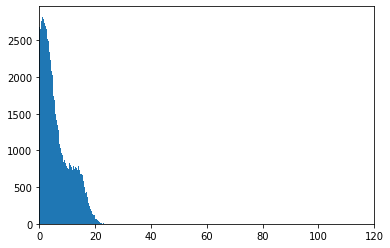

In [ ]:
plt.hist(dataDict['Mo'], bins=100);
plt.xlim(0, 120)

[2.15, 150.0, -275.0, 7.5]


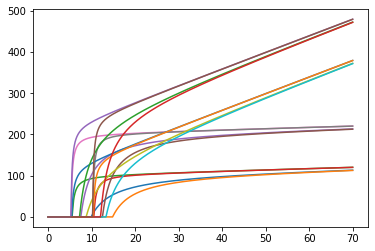

In [ ]:
# Adjusted parameters for prag
# Std parameters
aRange = [.3, 4]
bRange = [100, 200]
cRange = [-500, -50]
tRange = [5, 10]

'''
# Prag
aRange = [.3, .5]
bRange = [50, 150]
cRange = [-500, -50]
tRange = [5, 10]
'''

p_norm = [np.mean(aRange), np.mean(bRange), np.mean(cRange), np.mean(tRange)]
print(p_norm)

a, b, c, t = 2.15, 125, -525, 10
x = np.linspace(0, 70, 1000)

for a in aRange:
    for b in bRange:
        for c in cRange:
            for t in tRange:
                plt.plot(x, energyToToTSimple(x, a, b, c, t))

100%|██████████| 10/10 [00:00<00:00, 33.06it/s]


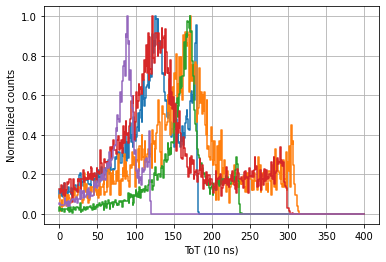

In [ ]:
frac = [(1, 1), (1, 3)]
# specGen = genSpectrum(sources, dataDict, frac, batch_size=3, sigmaParams0=None)
specGen = genSpectrum(sources, dataDict, frac,
                aRange=aRange, bRange=bRange, 
                cRange=cRange, tRange=tRange,
                NRange=(10000, 100000), sigmaParams0=None,
                p_norm=p_norm, batch_size=10,
                progress=False)
hist = next(specGen)[0][:5]

bins = np.arange(400)
for h in hist:
    plt.step(bins, h.flatten())
plt.grid()
plt.xlabel('ToT (10 ns)')
plt.ylabel('Normalized counts')
# plt.xlim(0, 70)
plt.show()

In [ ]:
specGen = genSpectrum(sources, dataDict, frac,
                aRange=aRange, bRange=bRange, 
                cRange=cRange, tRange=tRange,
                NRange=(10000, 100000), sigmaParams0=None,
                p_norm=p_norm, batch_size=60000,
                progress=False)
x_train, y_train = next(specGen)
specGen = genSpectrum(sources, dataDict, frac,
                aRange=aRange, bRange=bRange, 
                cRange=cRange, tRange=tRange,
                NRange=(10000, 100000), sigmaParams0=None,
                p_norm=p_norm, batch_size=10000,
                progress=False)
x_eval, y_eval = next(specGen)

100%|██████████| 10000/10000 [04:07<00:00, 40.41it/s]


In [ ]:
dump_json(directory + 'train_small_newCalFunc.json', x_train, y_train)
dump_json(directory + 'eval_small_newCalFunc.json', x_eval, y_eval)